### 尝试边界

In [4]:
%pylab inline
from abmdiffuse import Diffuse
import numpy as np
import pylab as pl
import networkx as nx

Populating the interactive namespace from numpy and matplotlib


In [6]:
def generate_random_graph(degre_sequance):
    G = nx.configuration_model(degre_sequance, create_using=None, seed=None)
    G = nx.Graph(G)
    G.remove_edges_from(G.selfloop_edges())
    return G

def func(p, q, g):
    diff = Diffuse(p, q, g=g, num_runs=40)
    x = np.mean(diff.repete_diffuse(), axis=0)
    return np.concatenate(([p, q], x))

In [7]:
expon_seq = np.load('dataSources/exponential_sequance.npy')
gauss_seq = np.load('dataSources/gaussian_sequance.npy')
logno_seq = np.load('dataSources/lognormal_sequance.npy')
g_cont = [nx.barabasi_albert_graph(10000, 3), generate_random_graph(expon_seq), generate_random_graph(gauss_seq),
          nx.gnm_random_graph(10000, 100000), nx.gnm_ran
          dom_graph(10000, 30000),
          nx.gnm_random_graph(10000, 40000), nx.gnm_random_graph(10000, 50000), nx.gnm_random_graph(10000, 60000),
          nx.gnm_random_graph(10000, 70000), nx.gnm_random_graph(10000, 80000), nx.gnm_random_graph(10000, 90000),
          generate_random_graph(logno_seq),
          nx.watts_strogatz_graph(10000, 6, 0), nx.watts_strogatz_graph(10000, 6, 0.1),
          nx.watts_strogatz_graph(10000, 6, 0.3), nx.watts_strogatz_graph(10000, 6, 0.5),
          nx.watts_strogatz_graph(10000, 6, 0.7), nx.watts_strogatz_graph(10000, 6, 0.9),
          nx.watts_strogatz_graph(10000, 6, 1)]

txt_cont = ['barabasi_albert_graph(10000,3)', 'exponential_graph(10000,3)', 'gaussian_graph(10000,3)',
            'gnm_random_graph(10000,100000)', 'gnm_random_graph(10000,30000)',
            'gnm_random_graph(10000,40000)', 'gnm_random_graph(10000,50000)', 'gnm_random_graph(10000,60000)',
            'gnm_random_graph(10000,70000)', 'gnm_random_graph(10000,80000)', 'gnm_random_graph(10000,90000)',
            'lognormal_graph(10000,3)',
            'watts_strogatz_graph(10000,6,0)', 'watts_strogatz_graph(10000,6,0.1)',
            'watts_strogatz_graph(10000,6,0.3)', 'watts_strogatz_graph(10000,6,0.5)',
            'watts_strogatz_graph(10000,6,0.7)', 'watts_strogatz_graph(10000,6,0.9)',
            'watts_strogatz_graph(10000,6,1.0)']

In [ ]:
bound_dict = {}
for j, g in enumerate(g_cont):
    t1 = time.clock()
    print(j+1, txt_cont[j])
    p_cont = (0.0003, 0.02)  
    q_cont = (0.076*3.0/(j + 4), 0.12*3.0/(j + 4))  # 小心设置
    delta = (0.00031, 0.008*3.0/(j + 4))
    ger_samp = Gen_para(g=g, p_cont=p_cont, q_cont=q_cont, delta=delta)
    bound_dict[txt_cont[j]] = ger_samp.identify_range()
    print(f'time: {time.clock() - t1:.2f}s')

f = open('dataSources/bound_artinetworks.pkl', 'wb')
pickle.dump(bound_dict, f)
f.close()

Time elasped:15.95s
最大采纳量614.8, 最大时间步:21


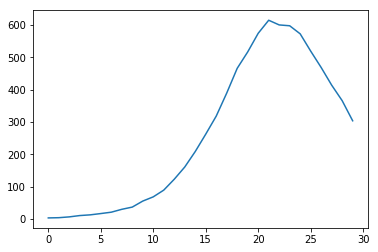

In [21]:
t1 = time.perf_counter()
g = g_cont[2]
p, q = 0.0003, 0.05
diff = Diffuse(p, q, g)
diff_cont = diff.repete_diffuse()
print(f"Time elasped:{time.perf_counter()-t1:.2f}s")
x = np.mean(diff_cont, axis=0)
print(f"最大采纳量{np.max(x)}, 最大时间步:{np.argmax(x)}")
pl.plot(x)